In [50]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [51]:
# Auctions parameters
n_users = 100       # number of users each day
K_bids = 80        # number of available bids
n_advertisers = 4  # number of advertisers other than us
B = 5              # budget
rho = B/n_users    # budget per round
n_slots = 1        # number of slots
value = 0.8        # value of bidders
available_bids = np.linspace(0,1,K_bids) # bid discretization

In [52]:
# Auctions Environment
class GeneralFirstPriceAuction:
    def __init__(self, ctrs, n_slots):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
        self.n_slots = n_slots

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-self.n_slots:]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        payment = values[winners]/self.ctrs[winners]
        return payment.round(2)
    
    def round(self, bids):
        winners, values = self.get_winners(bids)
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [53]:
# Auctions Agent

# Regret minimizer for multiplicative pacing
class RegretMinimizer_Hedge:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

# Multiplicative pacing agent non-trivial
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = RegretMinimizer_Hedge(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

# multiplicative pacing agent truthful
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)
    
    def update(self, f_t, c_t, m_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= c_t

# UCB
class UCBBiddingAgent:
    def __init__(self, bids_set, budget, valuation, T):
      self.bids_set = bids_set
      self.budget = budget
      self.valuation = valuation
      self.T = T
      self.rho = self.budget/self.T
      self.t = 0
      self.bids_history = []
      self.f = []
      self.c = []

    def bid(self):
        if self.budget < 1:
          self.bids_history.append(0)
          return 0
        elif self.t<len(self.bids_set):
          self.bids_history.append(self.bids_set[self.t])
          return self.bids_set[self.t]
        else:
          f_opti, c_opti, sup, best_bid = 0, 0, 0, 0
          for bid in self.bids_set:
            f_t = 0
            c_t = 0
            N = 0
            for i in range(self.t):
              if (self.bids_history[i] == bid):
                f_t += self.f[i]
                c_t += self.c[i]
                N += 1
            f_t = f_t/N
            c_t = c_t/N
            f_ucb = f_t + np.sqrt(2*math.log(self.T)/N)
            c_lcb = c_t - np.sqrt(2*math.log(self.T)/N)
            if (c_lcb<=self.rho and f_ucb>sup):
              sup = f_ucb
              f_opti = f_t
              c_opti = c_t
              best_bid = bid
          self.bids_history.append(best_bid)
          return best_bid

    def update(self, f_t, c_t, m_t):
      self.f.append(f_t)
      self.c.append(c_t)
      self.budget -= c_t
      self.t += 1

In [54]:
# Play against each other
number_agents = 4
n = number_agents*3
auctionsEnv = GeneralFirstPriceAuction(np.ones(n), n_slots) # assuming all advertisers have the same CTR=1 ie their ads are clicked with probability 1
eta = 1/np.sqrt(n_users)

agent_reward = np.array([])
expected_agent_reward = np.array([])

counter = 0

values = [value, 0.7, 0,7, 0,8]
agents = []

utilities = np.zeros((n_users,n))
bids = np.zeros((n_users,n))
payments = np.zeros((n_users,n))

for i in range(number_agents):
    agents.append(MultiplicativePacingAgent(values[i], B, n_users, eta))
    agents.append(FFMultiplicativePacingAgent(available_bids, values[i], B, n_users, eta))
    agents.append(UCBBiddingAgent(available_bids, B, values[i], n_users))


for u in range(n_users):
    # AUCTIONS ROUND
    bid_t = [agent.bid() for agent in agents]
    winners, payments_per_click = auctionsEnv.round(bid_t)
    fs_t, cs_t = np.zeros(n), np.zeros(n)
    for i, winner in enumerate(winners):
        cs_t[winner] = payments_per_click[i]
        fs_t[winner] = values[i//3]-cs_t[winner]
    m_t = bid_t[winners[-1]]
    # update auctions agent
    for i, agent in enumerate(agents):
        agent.update(fs_t[i], cs_t[i], m_t)
    # update reward sequence
    utilities[u] = fs_t
    payments[u] = cs_t
    bids[u] = bid_t


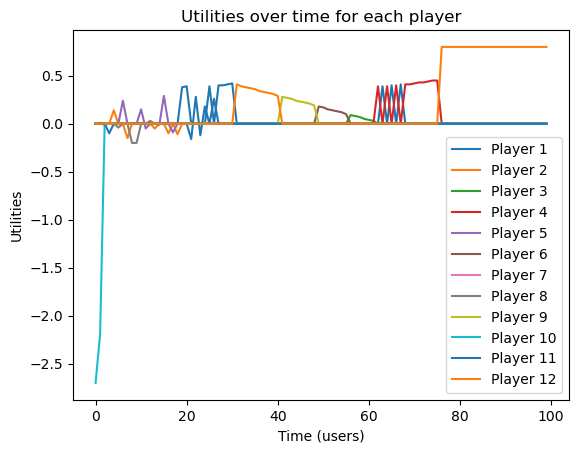

In [55]:
# Plot the utilities over time for each of the 6 players
for i in range(n):
    plt.plot(utilities[:, i], label=f'Player {i+1}')

plt.xlabel('Time (users)')
plt.ylabel('Utilities')
plt.title('Utilities over time for each player')
plt.legend()
plt.show()

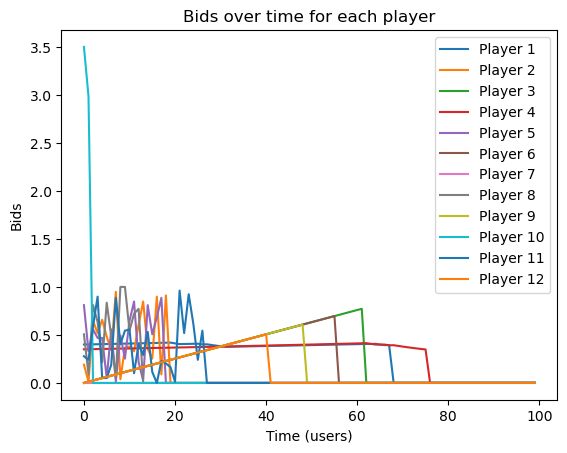

In [56]:
# Plot the utilities over time for each of the 6 players
for i in range(n):
    plt.plot(bids[:, i], label=f'Player {i+1}')

plt.xlabel('Time (users)')
plt.ylabel('Bids')
plt.title('Bids over time for each player')
plt.legend()
plt.show()

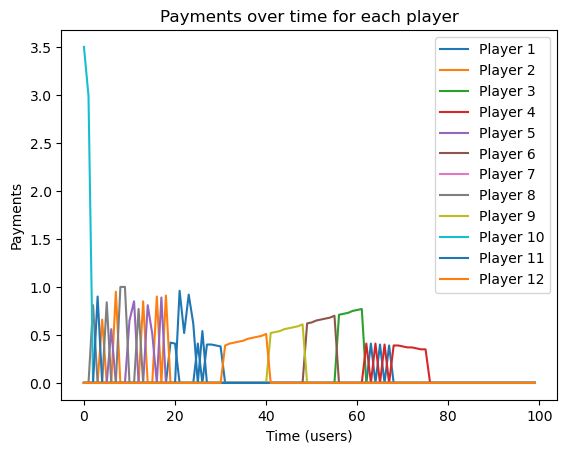

In [57]:
# Plot the utilities over time for each of the 6 players
for i in range(n):
    plt.plot(payments[:, i], label=f'Player {i+1}')

plt.xlabel('Time (users)')
plt.ylabel('Payments')
plt.title('Payments over time for each player')
plt.legend()
plt.show()